# Premise
Or background.

Supervisory control theory is brought up early 80s'. 

# Import packages

In [1]:
import pandas as pd
import numpy as np
import os, sys
from matplotlib import pyplot as plt
from Utility.Hygraph_json import Hyper_Read
import hypernetx as hnx

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


In [2]:
# load hypergraph and nodes name data
# add current directory to path
sys.path.append(os.getcwd())

node_json_path = r'./handlingcase/'
# check if route exists
if not os.path.exists(node_json_path):
    print('nodes.json not found')
    sys.exit(1)
else:
    json_files = [file for file in os.listdir(node_json_path) if file.endswith('.json')]
    print("json files are:", json_files)

# check file names and assign to node and edge json
if "edge" in json_files[0]:
    edge_json = json_files[0]
    node_json = json_files[1]
else:
    edge_json = json_files[1]
    node_json = json_files[0]

edge_path = os.path.join(node_json_path, edge_json)
node_path = os.path.join(node_json_path, node_json)
print("edge path is:", edge_path)
print("node path is:", node_path)

json files are: ['Handling_hyperedges.json', 'Handling_nodes.json']
edge path is: ./handlingcase/Handling_hyperedges.json
node path is: ./handlingcase/Handling_nodes.json


### Convert json files into node, edge data frame

In [3]:
node = Hyper_Read(node_path).js2df()
edge = Hyper_Read(edge_path).js2df()
edge

return hyperedges data


,id,hyperedge
0,0,[0]
1,1,"[0, 2]"
2,2,"[1, 2]"
3,3,"[1, 3]"
4,4,"[2, 3]"
5,5,[3]


## Graph
As you can see, the edge denotes with ``id`` of the nodes. It explains that there exists a relationship of the nodes. <br/>
For example, the first edge, i.e., edge ``id == 1`` denotes that nodes `0` and `1` are tangled with the requirement or plants original design assertion by engineer. <br/>

Hence, the whole transitional relationships can be reprsented by a graph. With edges as the linkage between nodes, and nodes are presented as the component that engineers defined.<br/>

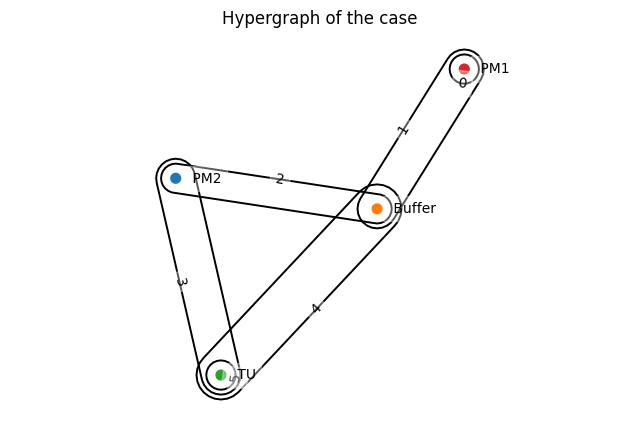

In [4]:
from Utility.data_func import Graph_conv
G1 = Graph_conv(edge, node)
graph1 = hnx.Hypergraph(G1)

from collections import defaultdict
# make a plot function
colors = defaultdict(lambda: plt.cm.tab10(len(colors)%10))
def get_node_color(v):
    return colors[v]
cmap = plt.cm.Blues
alpha = .2
sizes = np.array([graph1.size(e) for e in graph1.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

fig, axs = plt.subplots(1,1, figsize = (8, 5))
hnx.draw(graph1, 
        ax = axs,
         with_node_labels=True, 
         with_edge_labels=True, 
         node_labels_kwargs={
                'fontsize': 10
         },
         nodes_kwargs = {
             'color': get_node_color
         },
         edge_labels_kwargs = {
            'fontsize': 10,
         },
         edges_kwargs = {'linewidth':1.4,
                         'edgecolors': 'black',
        },
)
plt.title('Hypergraph of the case')
# plt.savefig('hypergraph.png')
plt.show()

## Incidence matrix and adjacency matrix (Design structure matrix)

The current case (data in *handlingcase* folder) represents with relationships between components, the relationships which are established through requirements designed with engineers. <br/>

The relationships are also established when their transition rules are settled. The detail of how the case data is constructed can reference the ESCET documentation. <br/>


The source data is recorded with nodes, and edges. Their data form can be viewed as a hypergraph. A hypergraph is a special graph that allows multiple nodes on the same edge. <br/>

Hence, we can check its incidence matrix first.

The incidence matrix $H$ of a hypergraph with $|V|$ columns and $|E|$ rows, $H$, then can be expressed as:
$$
\begin{equation}
    H_{ij} =
\begin{cases}
1 & \text{if } v_i \in e_j \\
0 & \text{otherwise}.
\end{cases}
\end{equation}
$$
An adjacency matrix is a square matrix that represents the transition relationships in pairs of nodes, which are indexed by the vertices of $H$ with $\forall i, j \in V, i \neq j$, and the entry of the adjacency matrix is $a_{i,j} = |\{e \in E: i,j \in e\}|$, with $a_{i,i}=0$.

In [5]:
from Utility.Hypergraph_matrix import Hyper_matrix
w = np.ones(len(node)) # initial as unit array
H = Hyper_matrix(edge_path, node, edge, w, edge).IncidenceMatrix_H()
print("Incidence matrix is:\n", H)
mat, rindex = graph1.adjacency_matrix(s=1, index=True)
print("adjacency matrix is:\n", mat.todense())
print("Componenet index as: ",rindex)

Incidence matrix is:
 [[1 1 0 0 0 0]
 [0 0 1 1 0 0]
 [0 1 1 0 1 0]
 [0 0 0 1 1 1]]
adjacency matrix is:
 [[0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]]
Componenet index as:  [' Buffer' ' PM1' ' PM2' ' TU']


Currently, the popular variable reorder algorithms for deriving variables ordering reference the adjacency matrix, or design structure matrix, to derive the variable ordering sequence for supervisor synthesis. <br/>

For example, one can utilize the Sloan ordering algorithm to sort variable ordering sequence based on the given matrix.

### Sloan order method

“Each node in the queue has a priority which is determined so that a low current degree and a large distance from the end node ensures a high priority.” (Sloan, 1989, p. 2656) 

The node with the highest priority is chosen as the next node to be labelled and then deleted from the queue. 

“The queue is then updated using the <font color="#e36c09">connectivity information</font> for the graph and the whole process is repeated until all the nodes have been labelled.” (Sloan, 1989, p. 2656)

Overall, it places non-zero elements near the diagonal to result in a lower profile of the matrix.

#### A case for Sloan ordering
For the purpose of showing the ordering effective, I choose a case that has larger size of nodes and edges. <br/>
In addition, I merge the edge and nodes data into a signle `json` file.

Load case: Bridge


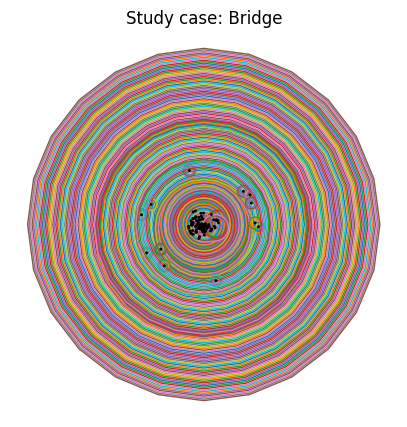

In [13]:
from Utility.Hyper_read import *
from Utility.Hypergraph_matrix import Hyper_matrix
from Utility.Clustering import *
from Utility.sloan import *
file_read = r'./data/'
files = os.listdir(file_read)
data = [file for file in files if file.endswith('data.json')]
file_dir_ = os.path.join(file_read, data[0])

Graph = Hyper_Read(file_dir_).df_2_Hypergraph() # whole graph
Title = Read_graph(file_dir_).return_graph_title()
print(f"Load case: {Title}")

nodes = Hyper_Read(file_dir_).js2df()[0]
edges = Hyper_Read(file_dir_).js2df()[1]
# make the edges into the graph
Graph = {}
for key in edges:
    Graph[key] = edges[key]['nodes']
H = hnx.Hypergraph(Graph)
Graph = H
# %matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title(f'Study case: {Title}')
hnx.draw(Graph, ax=ax, with_edge_counts=False, with_node_counts=False, with_node_labels=False, with_edge_labels=False)

## Cluster
The purpose of clustering here is to group the nodes into clusters, making a subgraphs with the nodes that are closely related to each other.

In [14]:
from sklearn.cluster import SpectralClustering
adj_original = Hyper_matrix(file_dir_, nodes, edges, w=None).AdjacencyMatrix_A().astype(np.float64)
degree = Hyper_matrix(file_dir_, nodes, edges, w=None).Deg_Vertex(diag=False)
name_label = 'cluster_label'
Spectral_clusterer = SpectralClustering(assign_labels="discretize",random_state=0, eigen_solver='arpack', n_clusters=3)
Spectral_result = Spectral_clusterer.fit(adj_original) # can also replace with another feature symmetrical matrix
Spectral_Ap = ClusterToFile(nodes=nodes,edges=edges, clusters_label=Spectral_result.labels_, savefile=False, name = name_label, Adj= adj_original, D_V=degree)

Spectral_Ap

c:\Users\lynch\anaconda3\envs\BDD\lib\site-packages\sklearn\cluster\_spectral.py:688: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
c:\Users\lynch\anaconda3\envs\BDD\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,label,cluster_label,id,Adj,Degree
0,BB.Alternate,0,0,0.0,0.0
89,VTL3.Red2,0,89,0.0,0.0
87,VTL3.GreenStaysOff,0,87,0.0,54.0
85,VTL3.Actuator,0,85,0.0,41.0
84,VTL3.Activated,0,84,0.0,2.0
...,...,...,...,...,...
39,BR.Sensor,2,39,0.0,132.0
29,BD.Direction,2,29,0.0,164.0
3,BB1.Closed,2,3,0.0,261.0
13,BB2.Closed,2,13,0.0,261.0


In [15]:
from Utility.Sort_clustering import *
PPnodes_spec = []
for i in range(Spectral_Ap.cluster_label.max()+1):
    if any(Spectral_Ap[Spectral_Ap[name_label]==i].count() == 0):
        print(f"cluster {i} is empty")
        continue
    Target_Sp = Spectral_Ap[Spectral_Ap[name_label]== i]
    PPnodes_spec.append(Subgraph_PPnode(file_directory=file_dir_, cluster=Target_Sp, E= edges, Graph= Graph))
SP = order4DS(data = Spectral_Ap, r=PPnodes_spec, name_C=name_label).DS_sorting4clusters(Spectral_Ap)
SP

c:\Users\lynch\anaconda3\envs\BDD\lib\site-packages\hypernetx\classes\entity.py:1392: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[
c:\Users\lynch\anaconda3\envs\BDD\lib\site-packages\hypernetx\classes\entity.py:1392: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  properties[self._misc_props_col] = self.properties[


,label,cluster_label,id,Adj,Degree
0,BB.Alternate,0,0,0.0,0.0
1,StopSigns.S1StaysOff,0,59,0.0,0.0
2,StopSigns.S2StaysOff,0,61,0.0,0.0
3,StopSigns.S3,0,62,0.0,0.0
4,StopSigns.S3StaysOff,0,63,0.0,0.0
...,...,...,...,...,...
127,BR.Actuator,2,37,0.0,133.0
128,BD.Direction,2,29,0.0,164.0
129,BB1.Closed,2,3,0.0,261.0
130,BB2.Closed,2,13,0.0,261.0


### Print rordering result

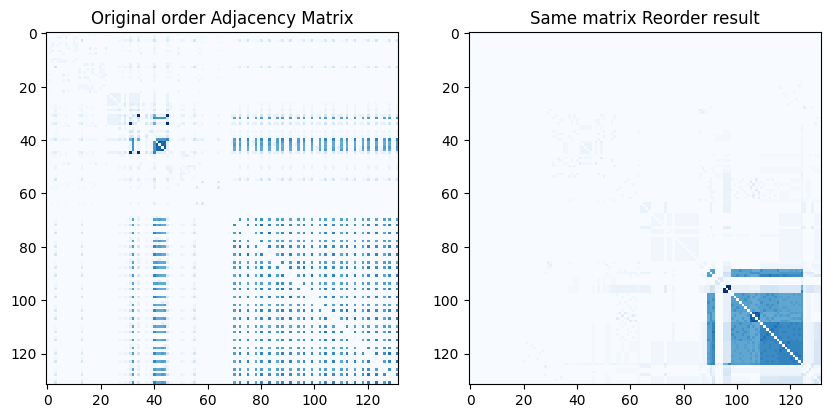

In [19]:
from Utility.data_func import reorder_symmetric
SP['New_id'] = SP.index.tolist()
SP['id'].astype(int)
SP['New_id'].astype(int)
new_matrix = reorder_symmetric(adj_original, SP['id'].tolist())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original order Adjacency Matrix')
axs[0].imshow(adj_original, cmap='Blues', interpolation='nearest')
axs[1].set_title('Same matrix Reorder result')
axs[1].imshow(new_matrix, cmap='Blues', interpolation='nearest')
# plt.savefig('Spectral_reorder.png')
plt.show()